In [2]:
from numpy import fft
import random
import time
from skimage.transform import resize
import warnings
def ift2(G, delta_f ,FFT=None):
    """
    Wrapper for inverse fourier transform
    Parameters:
        G: data to transform
        delta_f: pixel seperation
        FFT (FFT object, optional): An accelerated FFT object
    """
        
    N = G.shape[0]

    if FFT:
        g = numpy.fft.fftshift( FFT( numpy.fft.fftshift(G) ) ) * (N * delta_f)**2
    else:
        g = fft.ifftshift( fft.ifft2( fft.fftshift(G) ) ) * (N * delta_f)**2

    return g

def ft_phase_screen(r0, N, delta, L0, l0, FFT=None, seed=None):
    '''
    Creates a random phase screen with Von Karmen statistics.
    (Schmidt 2010)
    
    Parameters:
        r0 (float): r0 parameter of scrn in metres
        N (int): Size of phase scrn in pxls
        delta (float): size in Metres of each pxl
        L0 (float): Size of outer-scale in metres
        l0 (float): inner scale in metres
    Returns:
        ndarray: numpy array representing phase screen
    '''
    delta = float(delta)
    r0 = float(r0)
    L0 = float(L0)
    l0 = float(l0)

    R = random.SystemRandom(time.time())
    if seed is None:
        seed = int(R.random()*100000)
    np.random.seed(seed)

    del_f = 1./(N*delta)

    fx = np.arange(-N/2.,N/2.) * del_f

    (fx,fy) = np.meshgrid(fx,fx)
    f = np.sqrt(fx**2 + fy**2)

    fm = 5.92/l0/(2*np.pi)
    f0 = 1./L0

    PSD_phi  = (0.023*r0**(-5./3.) * np.exp(-1*((f/fm)**2)) /
                ( ( (f**2) + (f0**2) )**(11./6) ) )

    PSD_phi[int(N/2), int(N/2)] = 0

    cn = ( (np.random.normal(size=(N,N)) + 1j* np.random.normal(size=(N,N)) )
                * np.sqrt(PSD_phi)*del_f )

    phs = ift2(cn,1, FFT).real


    return phs

In [3]:
D = 3
r0 = 0.15
N = 512 
delta = D/N
L0, l0 = 100, 0.10
wavelength1 = 550e-9
phase_screen=ft_phase_screen(r0,N,delta,L0,l0)

enter n  4


384 128 384 128
[128 128 128 ... 384 384 384]


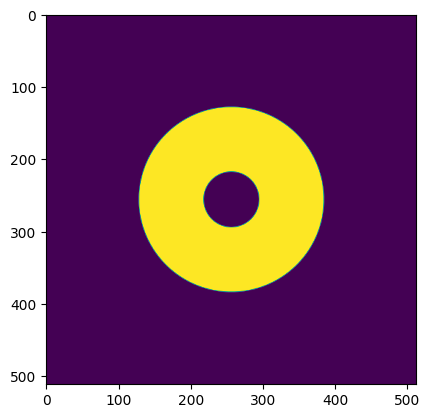

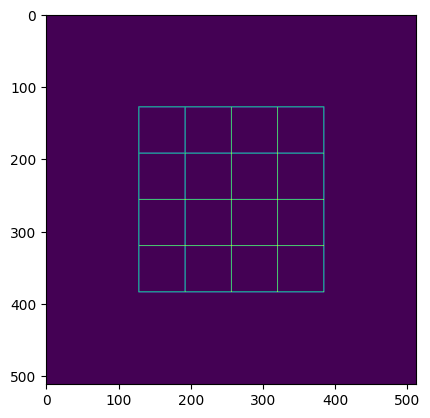

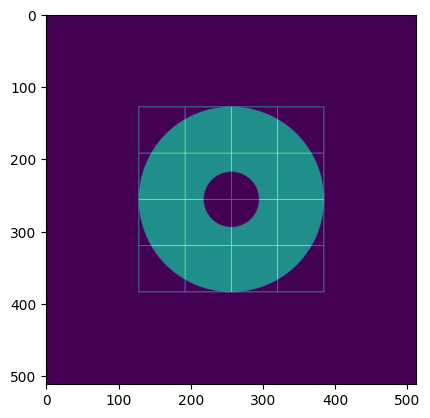

In [4]:
%matplotlib inline
import proper
import numpy as np
import matplotlib.pyplot as plt
n=int(input('enter n '))
conf=dict(
diam = 0.2794,
focal_ratio = 15.0,
wavelength = 550e-9,
gridsize = 512,
#pixelsize = 45.25, # mas/pix
pixelsize = 50, # mas/pix
sec_obs = 0.30)
scale=1
proper.print_it = False
conf['beam_ratio'] = 0.5
conf['pixelsize']*4.85e-9/(scale*conf['wavelength']/conf['diam'])
focal_length = conf['diam'] * conf['focal_ratio']

wfo = proper.prop_begin(conf['diam'], conf['wavelength'], conf['gridsize'], conf['beam_ratio'])

# Define a circular aperture
proper.prop_circular_aperture(wfo, conf['diam']/2)
if conf['sec_obs'] == 0:
        None
else:
        proper.prop_circular_obscuration(wfo, conf['sec_obs']*conf['diam']/2)
# Define entrance
proper.prop_define_entrance(wfo)
#pupil=proper.prop_get_amplitude(wfo)
#plt.figure()
#plt.imshow(pupil)
proper.prop_add_phase(wfo, phase_screen*conf['wavelength']/(2*np.pi))#2.546479089e-7
pupil=proper.prop_get_amplitude(wfo)
plt.figure()
plt.imshow(pupil)
pupil_normalized = (pupil - pupil.min()) / (pupil.max() - pupil.min())
y, x = np.nonzero(pupil)
max_x, min_x = x.max(), x.min()
max_y, min_y = y.max(), y.min()
print(max_x, min_x,max_y, min_y)
subaperture_size_y = (max_y - min_y) / n
subaperture_size_x = (max_x - min_x) / n
# Create a square grid
grid_size = max(max_x - min_x, max_y - min_y)
#n=int(np.ceil((grid_size*conf['diam']/conf['gridsize'])/subaperture_size))
#print(n)
grid = np.zeros((conf['gridsize'], conf['gridsize']))
grid[min_y, min_x:max_x + 1] = 1  # Bottom horizontal line
grid[max_y, min_x:max_x + 1] = 1  # Top horizontal line
grid[min_y:max_y + 1, min_x] = 1  # Left vertical line
grid[min_y:max_y + 1, max_x] = 1
for i in range(1, n):
    y_line = int(min_y + i * subaperture_size_y)
    x_line = int(min_x + i * subaperture_size_x)
    grid[y_line, min_x:max_x + 1] = 1  # Horizontal line
    grid[min_y:max_y + 1, x_line] = 1  # Vertical line
plt.figure()
plt.imshow(grid)
combined = grid + pupil_normalized
plt.figure()
plt.imshow(combined)
print(y)

In [5]:
f = np.zeros((n+1, n+1), dtype=[('x', int), ('y', int)])
fractions = np.zeros((n+1, n+1))
for i in range(n+1):
    for j in range(n+1):
        y_start = int(min_y + i * subaperture_size_y)
        y_end = int(y_start + subaperture_size_y)
        x_start = int(min_x + j * subaperture_size_x)
        x_end = int(x_start + subaperture_size_x)
        f[i, j] = (int((x_start + x_end) / 2), int((y_start + y_end) / 2))
        subaperture_pupil = pupil_normalized[y_start:y_end, x_start:x_end]
        fractions[i, j] = np.sum(subaperture_pupil) / (subaperture_size_y * subaperture_size_x)
print(fractions)
print(f)

[[3.03795681e-01 9.03292065e-01 9.07468685e-01 3.15112910e-01
  0.00000000e+00]
 [9.03292065e-01 7.26576624e-01 7.17321475e-01 9.18073670e-01
  8.43394886e-04]
 [9.07468685e-01 7.17321475e-01 7.07822185e-01 9.22137300e-01
  9.56385589e-04]
 [3.15112910e-01 9.18073670e-01 9.22137300e-01 3.26674280e-01
  0.00000000e+00]
 [0.00000000e+00 8.43394886e-04 9.56385589e-04 0.00000000e+00
  0.00000000e+00]]
[[(160, 160) (224, 160) (288, 160) (352, 160) (416, 160)]
 [(160, 224) (224, 224) (288, 224) (352, 224) (416, 224)]
 [(160, 288) (224, 288) (288, 288) (352, 288) (416, 288)]
 [(160, 352) (224, 352) (288, 352) (352, 352) (416, 352)]
 [(160, 416) (224, 416) (288, 416) (352, 416) (416, 416)]]


In [11]:
print(f[0][1][0])

224


In [6]:
def photocenter(image, t=0.1):
    imax = np.percentile(image, 99.95) # maximum without possible hot pixels
    image -= t*imax # apply threshold (10% of max)
    image *= image > 0.0 # remove all negative values
    
    total = np.sum(image) # sum of the pixels
    X, Y = np.indices(np.shape(image)) # create two matrices with indices of each pixels
    cx = (np.sum(Y*image)/total) # calculate the photocenter in x and y
    cy = (np.sum(X*image)/total) 
    return(int(cx),int(cy))

In [23]:
%matplotlib qt
cr=8
a=0
b=1
spots = np.zeros((conf['gridsize'], conf['gridsize']))
for i in range(1,n+1):
    for j in range(1,n+1):
        x = int(i * subaperture_size_x)
        y = int(j * subaperture_size_y)
        # Create a new wavefront and apply the fraction for the current sub-aperture
        w = proper.prop_begin(conf['diam'], conf['wavelength'], conf['gridsize'], conf['beam_ratio'])
        proper.prop_circular_aperture(w, conf['diam'] / 2)
        proper.prop_define_entrance(w)
        pixel_x=f[i][j][0]
        pixel_y=f[i][j][1]
        for k in range(min_y, max_y + 1):
            for l in range(min_x, max_x + 1):
                if (y_start <= k < y_end) and (x_start <= l < x_end):
                    w.wfarr[k, l] *= fractions[i, j]
        proper.prop_add_phase(w, phase_screen*conf['wavelength']/(2*np.pi))#2.546479089e-7

        # Propagate the wavefront through a lens
        proper.prop_lens(w, focal_length)

        # Propagate to the focal plane
        proper.prop_propagate(w, focal_length)
        (psf,sampling)=proper.prop_end(w)
        start_x = pixel_x - cr
        end_x = pixel_x + cr
        start_y = pixel_y - cr
        end_y = pixel_y + cr
        # Ensure the indices are within the bounds of the spots array
        spots[start_y:end_y, start_x:end_x] = psf[y-cr:y+cr,x-cr:x+cr]
plt.figure()
plt.imshow(spots)